In [11]:
!curl -L -o creditcardfraud.zip https://www.kaggle.com/api/v1/datasets/download/mlg-ulb/creditcardfraud

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 65.9M  100 65.9M    0     0  10.9M      0  0:00:06  0:00:06 --:--:-- 11.2M


In [12]:
import zipfile

with zipfile.ZipFile("creditcardfraud.zip", "r") as zip_ref:
    zip_ref.extractall(".")

In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

In [14]:
df = pd.read_csv('./creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<Axes: xlabel='Class', ylabel='count'>

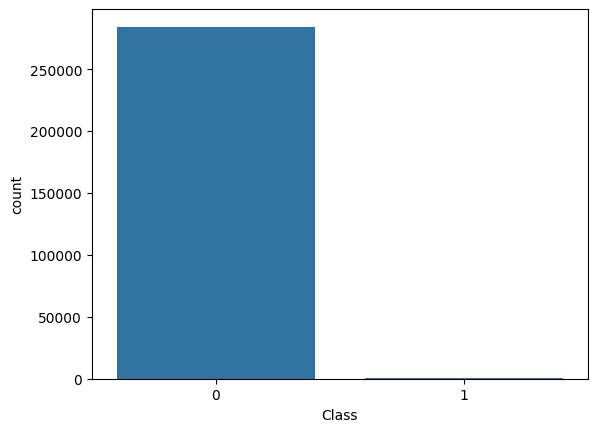

In [15]:
sns.countplot(x='Class', data=df)

In [16]:

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['Amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

In [17]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,0
1,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,0
2,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,0
3,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,0
4,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,0


In [18]:
df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
270310,0.931895,-1.593332,0.093556,0.630891,-0.821696,1.113369,-1.358810,1.076003,-0.324129,0.016231,...,-0.375594,-0.461650,0.583952,-0.020771,-0.125374,0.053479,-0.469809,-0.504820,-0.279746,0
42009,-0.514257,-2.740483,3.658095,-4.110636,5.340242,-2.666775,-0.092782,-4.388699,-0.280133,-2.821895,...,2.417495,-0.097712,0.382155,-0.154757,-0.403956,0.277895,0.830062,0.218690,1.262209,1
48348,-0.482748,-0.719583,0.982203,1.481568,0.956980,0.287250,-1.229339,0.889047,-0.122706,-0.748978,...,-0.293955,-0.909545,0.115828,0.644340,-0.124036,-0.678312,0.336083,0.193152,0.019842,0
151730,0.134435,-1.952933,3.541385,-1.310561,5.955664,-1.003993,0.983049,-4.587235,-4.892184,-2.516752,...,-1.998091,1.133706,-0.041461,-0.215379,-0.865599,0.212545,0.532897,0.357892,-0.042479,1
10690,-0.782481,-12.224021,3.854150,-12.466766,9.648311,-2.726961,-4.445610,-21.922811,0.320792,-4.433162,...,-1.159830,-1.504119,-19.254328,0.544867,-4.781606,-0.007772,3.052358,-0.775036,16.724516,1


<Axes: xlabel='Class', ylabel='count'>

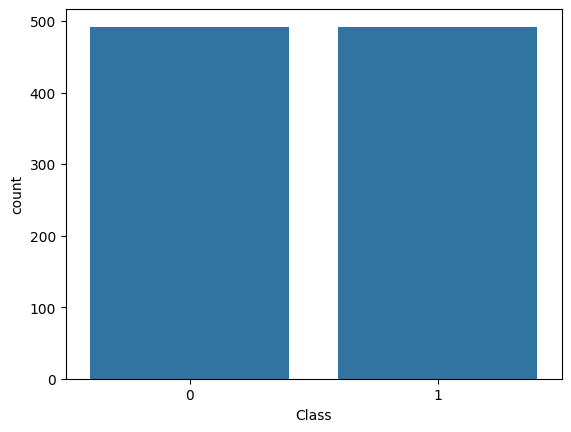

In [19]:
sns.countplot(x='Class', data=new_df)

In [28]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
X

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
195826,0.546811,1.992392,-0.524551,-0.274345,0.249401,-0.937411,-0.692022,-0.675612,-0.037864,1.619331,...,-0.248375,0.171386,0.720146,0.141563,0.047086,-0.190196,0.126281,0.011804,-0.043260,-0.181933
198868,0.563869,0.432554,1.861373,-4.310353,2.448080,4.574094,-2.979912,-2.792379,-2.719867,-0.276704,...,0.318853,-1.384477,-0.348904,-3.979948,-0.828156,-2.419446,-0.767070,0.387039,0.319402,-0.293440
21881,-0.620097,0.933172,-1.263936,0.392467,-1.200550,-1.438356,-0.610893,-0.527778,0.011798,2.193340,...,0.224616,0.179326,0.274763,-0.317542,-0.073363,0.427721,0.130174,-0.001827,0.048420,2.436247
154587,0.204678,-28.255053,21.467203,-26.871339,11.737436,-17.999630,6.065901,-41.506796,-38.987263,-13.434066,...,10.440718,-21.453736,8.361985,4.909111,0.098328,-1.508739,0.008711,-5.407824,-0.183811,-0.307413
251891,0.832435,1.878230,1.325630,-2.333469,4.233151,1.355184,-0.853508,0.716025,-0.164910,-1.502345,...,-0.226108,-0.152131,-0.360736,0.043414,-0.242380,0.171098,-0.002601,-0.026667,0.005238,-0.208761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150692,0.108225,-11.320633,7.191950,-13.179083,9.099552,-10.094749,-2.440115,-14.184337,4.452503,-6.241960,...,-0.180935,1.082235,-0.350563,0.483044,0.661133,-0.396522,-0.413315,-0.997548,-0.235036,0.222595
92777,-0.242002,-6.133987,2.941499,-5.593986,3.258845,-5.315512,-0.637328,-4.476488,1.695994,-1.606743,...,-0.815086,0.868340,0.793736,0.217347,-0.021985,0.145882,0.665088,-1.684186,0.310195,3.813317
185481,0.493345,2.140296,-2.045944,-1.367824,-2.507372,0.396248,4.056665,-2.399476,1.092292,-0.725767,...,-0.262159,-0.121927,0.010858,0.352017,0.675231,-0.523321,-0.229153,0.079036,-0.029147,0.447146
223366,0.689176,1.118331,2.074439,-3.837518,5.448060,0.071816,-1.020509,-1.808574,0.521744,-2.032638,...,0.163513,0.289861,-0.172718,-0.021910,-0.376560,0.192817,0.114107,0.500996,0.259533,-0.293440


In [30]:
y

195826    0
198868    1
21881     0
154587    1
251891    1
         ..
150692    1
92777     1
185481    0
223366    1
226877    1
Name: Class, Length: 984, dtype: int64